# **1. Download das Bibliotecas**

In [1]:
#%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1

In [2]:
#%pip install matplotlib yfinance scikit-learn scikit-optimize

# **2. Importações**

## Geral

In [3]:
# Importação de libs auxiliares
import numpy as np
import pandas as pd

# Importando as classes refatoradas
from preprocessamento.SeriesProcessor import SeriesProcessor
from otimizador.Optimizer import OtimizadorModelosSklearn
from avaliacao.AvaliadorDriftBase import AvaliadorBatch
from avaliacao.AvaliadorDriftBase import AvaliadorPassivo
from utils.Visualizer import Visualizer

# limpar o log
import warnings
#warnings.filterwarnings("ignore")

## Importação dos Detectores e Regressores Off-line e On-line

In [4]:
# Importando detectores de drift
from detectores.ADWINDetector import ADWINDetector
from detectores.DDMDetector import DDMDetector
from detectores.EDDMDetector import EDDMDetector
from detectores.FHDDMDetector import FHDDMDetector
from detectores.HDDM_ADetector import HDDM_ADetector
from detectores.PageHinkleyDetector import PageHinkleyDetector
from detectores.HDDM_WDetector import HDDM_WDetector
from detectores.KSWINDetector import KSWINDetector

In [5]:
# Importando modelos offline
from regressores.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from regressores.modelosOffline.KneighborsRegressorModelo import KneighborsRegressorModelo
from regressores.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from regressores.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from regressores.modelosOffline.SVRModelo import SVRModelo
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo
from regressores.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

In [6]:
# Importando modelos online
from regressores.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from regressores.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from regressores.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from regressores.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

# **3. Dados e Pré-processamento**

## Séries Temporais

In [7]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

## Parâmetros de processamento

In [8]:
# Definindo parâmetros para processamento
tamanho_batch = 100
lags = 5
serie_escolhida = series[0]
print(f"Processando série: {serie_escolhida}")

Processando série: AAPL


## Processamento dos dados

In [9]:
# Baixando os dados da ação
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1256, 1)
Shape dos dados de entrada: (1251, 5)
Shape dos dados de saída: (1251, 1)


# **4. Otimização de Hiperparâmetros**

In [10]:
arquivo_parametros = "melhores_parametros.json"
otimizador = OtimizadorModelosSklearn(n_iter=20)

In [11]:
melhores_parametros = otimizador.otimizar(
    X[tamanho_batch:], 
    Y[tamanho_batch:], 
    salvar_em = arquivo_parametros)

# **5. Definição dos Modelos**

## Regressores off-line

In [12]:
modelos_offline = [
    LinearRegressionModelo,
    KneighborsRegressorModelo,
    LassoRegressionModelo,
    MLPRegressorModelo,  
    RandomForestModelo,
    RidgeRegressionModelo,
    SVRModelo
]

## Regressores on-line

In [13]:
modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

# **6. Prequential com Detecção de Drift**

In [14]:
avaliador = AvaliadorBatch()
predicoes_ativo, deteccoes, mae_ativo = avaliador.executar_avaliacao(X, Y, tamanho_batch, LinearRegressionModelo, DDMDetector)


Drift detectado para KNN_HDDM nos índices: [480, 1085]


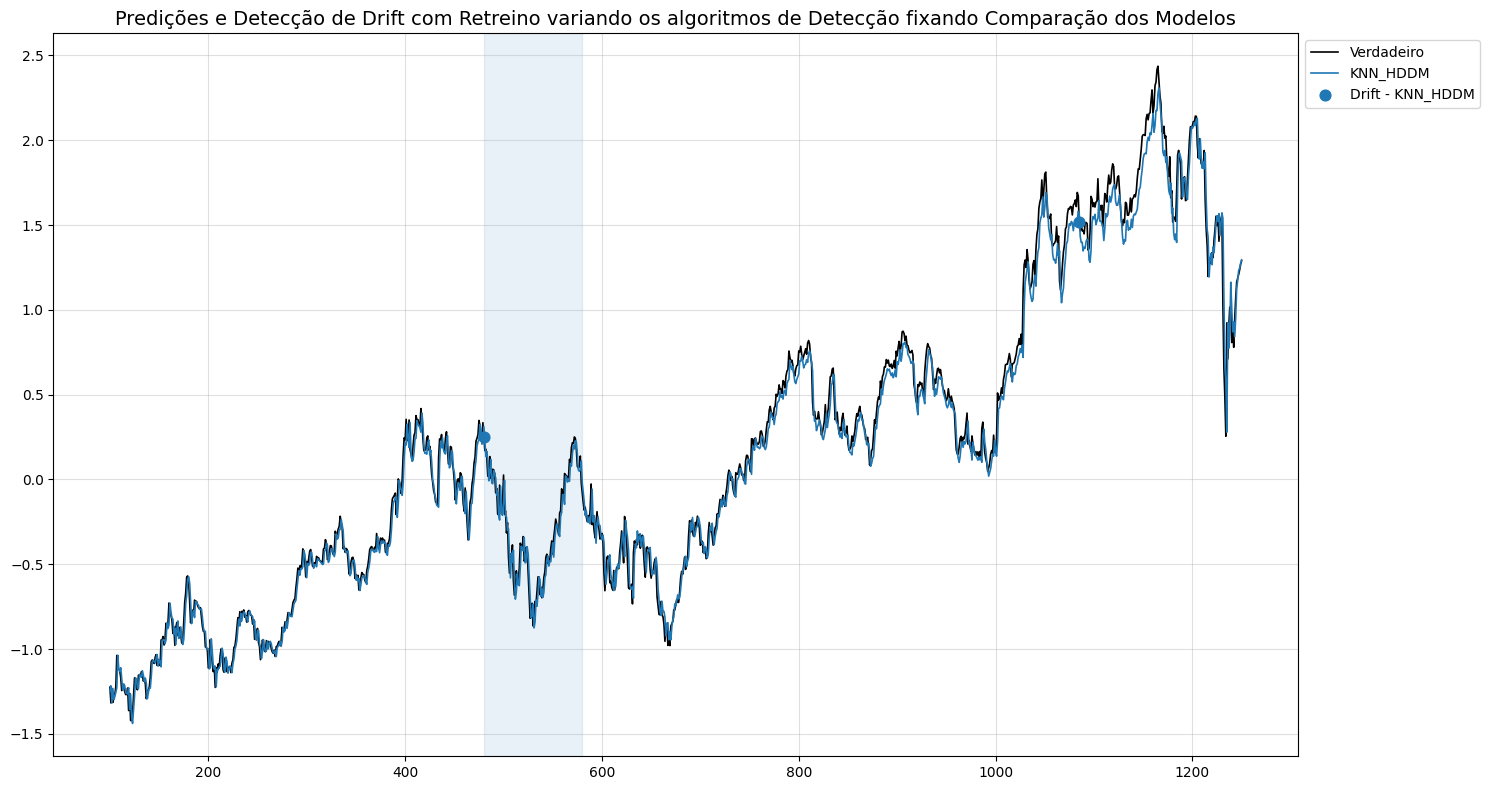

In [15]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo],
                  ["KNN_HDDM"],
                  {"KNN_HDDM": deteccoes},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )

In [16]:
modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

# **7. Prequential Passivo**

In [17]:
avaliador = AvaliadorPassivo()
predicoes_passivo, mae = avaliador.executar_avaliacao(X, Y, tamanho_batch, BayesianLinearRegressionModelo)


Drift detectado para KNN_HDDM nos índices: [480, 1085]


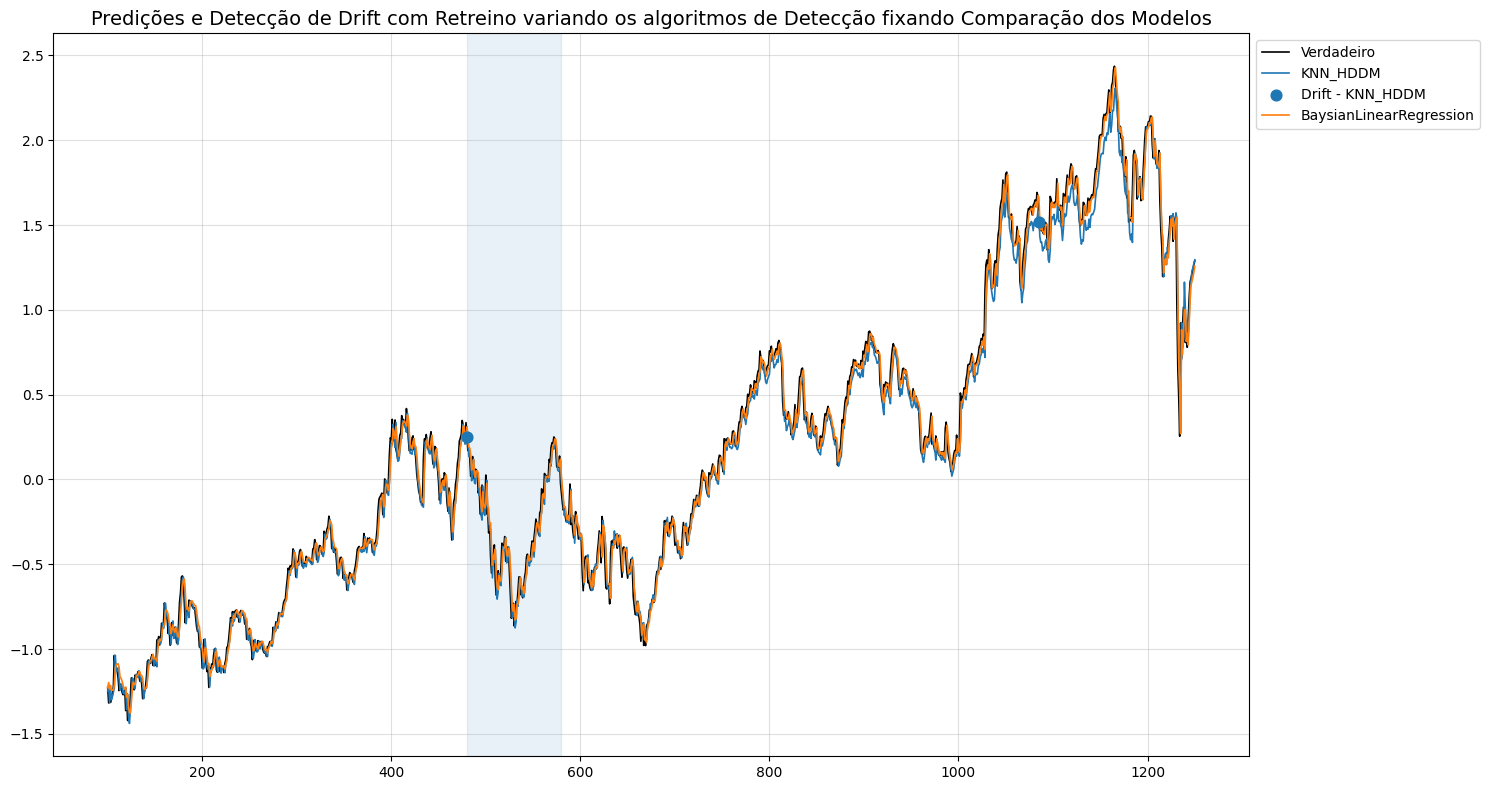

In [18]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo,
                   predicoes_passivo],
                  ["KNN_HDDM",
                   "BaysianLinearRegression"],
                  {"KNN_HDDM": deteccoes},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )